In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import shutil
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix,
                             roc_curve, precision_recall_curve, average_precision_score, ConfusionMatrixDisplay)

torch.manual_seed(10)

path_dir = '/Users/titouan/Desktop/Coughvid-COVID-Predictor/'

path_img_dir_train = path_dir + "Data/MelSpecs_train"
df_label_train = pd.read_csv(path_dir + "Data/MelSpecs_labels_train.csv")

path_img_dir_test = path_dir + "Data/MelSpecs_test"
df_label_test= pd.read_csv(path_dir + "Data/MelSpecs_labels_test.csv")


In [2]:
(train_df, val_df) = train_test_split(df_label_train, test_size=0.1, stratify=df_label_train["label"], random_state=10)

class MelSpectrogramDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        #self.label_dict = label_dict

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.iloc[idx]["label"]
        filename = self.df.iloc[idx]["filename"]

        # Read image
        img_path = os.path.join(self.img_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype(np.float32) / 255.0 #Normalize to [0, 1]
        img = img.transpose(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)


full_train_dataset = MelSpectrogramDataset(df_label_train, path_img_dir_train)
train_dataset = MelSpectrogramDataset(train_df, path_img_dir_train)
val_dataset = MelSpectrogramDataset(val_df, path_img_dir_train)
test_dataset = MelSpectrogramDataset(df_label_test, path_img_dir_test)

BATCH_SIZE = 256

full_train_loader = DataLoader(full_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

#FREE MEMORY
gc.collect()
torch.cuda.empty_cache()

Set Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Get one image to determine input dimensions
sample_img, _ = train_dataset[0]  # First image and label
input_dim = sample_img.shape  # (C, H, W)
print("Input shape:", input_dim)


cpu
Input shape: torch.Size([3, 199, 515])


Define the model

In [ ]:
from Models.CNN_LSTM import CNN_LSTM

# Build model
cnn_lstm = CNN_LSTM(input_dim=input_dim).to(device)

# Enable multi-GPU training if more than one GPU is available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    cnn_lstm = nn.DataParallel(cnn_lstm)

# Loss, optimiser, scheduler
EPOCHS =100
learning_rate = 1e-3
criterion_cnn_lstm = nn.BCEWithLogitsLoss()
optimizer_cnn_lstm = torch.optim.Adamax(cnn_lstm.parameters(), 
                                        lr=learning_rate, weight_decay=1e-4)

In [ ]:
###### TRAINING
# Metrics to keep track of, early stopping parameters
train_accuracies = []
val_accuracies = []
train_loss=[]
val_loss=[]
best_auc = 0.0
epochs_no_improve = 0
EPOCHS = 100
patience = 10
early_stop = False

for e in range(1, EPOCHS+1):
    # Iterate through the epochs
    running_loss = 0.0
    correct = 0
    total = 0
    for X_batch, y_batch in train_loader:
        # Iterate through the batches our dataloader created
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1)

        # This removes the stored gradient
        optimizer_cnn_lstm.zero_grad()

        # From forward propagation
        y_pred_logits = cnn_lstm(X_batch).view(-1)
        y_pred_proba = torch.sigmoid(y_pred_logits)
        label_predicted = (y_pred_proba >= 0.5).int()

        # Calculate the loss
        loss = criterion_cnn_lstm(y_pred_logits, y_batch.float())
        running_loss += loss.item()

        # Calculate accuracy
        total += y_batch.size(0)
        correct += (label_predicted == y_batch.int()).sum().item()

        # Perform backwards propagation
        loss.backward()
        # Update the weights
        optimizer_cnn_lstm.step()

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_loss.append(running_loss/len(train_loader))

    # Validate the model
    cnn_lstm.eval()  # Set the model to evaluation mode (no gradient computation)
    val_correct = 0
    val_total = 0
    val_running_loss=0.0
    all_val_probs = []
    all_val_labels = []

    with torch.no_grad():  # No gradients required for validation
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1)

            y_pred_logits = cnn_lstm(X_batch).view(-1) # Forward pass
            y_pred_proba = torch.sigmoid(y_pred_logits) # Convert logits to probabilities
            val_predicted = (y_pred_proba >= 0.5).int() # Binary prediction

            # For AUC calculations
            all_val_probs.extend(y_pred_proba.cpu().numpy())
            all_val_labels.extend(y_batch.cpu().numpy())

            loss = criterion_cnn_lstm(y_pred_logits, y_batch.float()) # Compute loss
            val_running_loss += loss.item()

            val_total += y_batch.size(0)
            val_correct += (val_predicted == y_batch.int()).sum().item() # Count correct predictions

    # Calulate AUC for model saving
    val_auc = roc_auc_score(all_val_labels, all_val_probs)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_loss.append(val_running_loss/len(val_loader))

    # Early stopping and save model with best AUC
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(cnn_lstm.state_dict(), path_dir + 'best_cnn_lstm.pth')
        print(f"Best model saved at epoch {e} with AUC = {best_auc:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {e}")
            early_stop = True

    if early_stop:
        break

    cnn_lstm.train() # Back to train mode

    # Print metrics for current model
    print(f'Epoch {e+0:03}: | Loss: {running_loss/len(train_loader):.5f} | Acc: {train_acc:.3f} | Validation Accuracy: {val_acc:.3f}')

torch.save(cnn_lstm.state_dict(), path_dir + "final_cnn_lstm.pth")

In [ ]:
def plot_train_val_accuracy(train_accuracies,val_accuracies, title='Training and Validation Accuracy', y_lims=[0, 1]):
    """
    Plots training and validation accuracy over epochs.

    Parameters
    ----------
    train_accuracies : list
        List of training accuracies per epoch.
    val_accuracies : list
        List of validation accuracies per epoch.

    Returns
    -------
    None
        Displays a plot of training and validation accuracy over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend()
    plt.grid()
    plt.savefig(path_dir + 'accuracy_augmented.png')

def plot_train_val_loss(train_loss,val_loss, title='Training and Validation Loss'):
    """
    Plots training and validation loss over epochs.

    Parameters
    ----------
    train_loss : list
        List of training accuracies per epoch.
    val_loss: list
        List of validation accuracies per epoch.

    Returns
    -------
    None
        Displays a plot of training and validation loss over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', marker='o')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig(path_dir +'loss_augmented.png')

plot_train_val_accuracy(train_accuracies, val_accuracies)
plot_train_val_loss(train_loss, val_loss)

In [ ]:
#Evaluate loaded model 
evaluate = False
if evaluate : 
    # Load the best model
    cnn_lstm.load_state_dict(torch.load('best_cnn_lstm.pth'))
    cnn_lstm.eval()

    # Initialize lists to store true labels and predicted probabilities
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1)

            y_pred_logits = cnn_lstm(X_batch).view(-1)
            y_pred_proba = torch.sigmoid(y_pred_logits)

            all_probs.extend(y_pred_proba.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate metrics
    auc_score = roc_auc_score(all_labels, all_probs)
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    average_precision = average_precision_score(all_labels, all_probs)

    print(f"AUC: {auc_score:.4f}")
    print(f"Average Precision: {average_precision:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')


In [ ]:
#EVALUATE LOADED MODEL

from Models.CNN_LSTM import CNN_LSTM
from collections import OrderedDict

evaluate = True
origin_dir = '/Users/titouan/Desktop/Coughvid-COVID-Predictor/results_CNN_LSTM/'

if evaluate :

    state_dict = torch.load(origin_dir + 'best_cnn_lstm.pth', map_location=device)
    #If trained in Parallel :  Remove 'module.' prefix from keys
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_k = k.replace('module.', '')  # remove 'module.' prefix
        new_state_dict[new_k] = v
    
    # Build model
    cnn_lstm = CNN_LSTM(input_dim=input_dim).to(device)
    cnn_lstm.load_state_dict(new_state_dict)
    cnn_lstm.eval()


In [5]:
if isinstance(cnn_lstm, nn.DataParallel):
    cnn_lstm = cnn_lstm.module

cnn_lstm.eval()

all_labels = []
all_probs = []

correct = 0
total = 0

with torch.no_grad():
    # Collect TEST features and labels
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = cnn_lstm(x_batch).view(-1) 
        y_pred_proba = torch.sigmoid(outputs)
        label_predicted = (y_pred_proba >= 0.5).int()

        total += y_batch.size(0)
        correct += (label_predicted == y_batch.int()).sum().item()

        all_labels.append(y_batch.int().cpu())
        all_probs.append(y_pred_proba.cpu())


Test Accuracy: 99.06 %, Precision: 97.60 %, Recall: 98.64 %, F1-Score: 98.12 %, AUC: 98.92 %


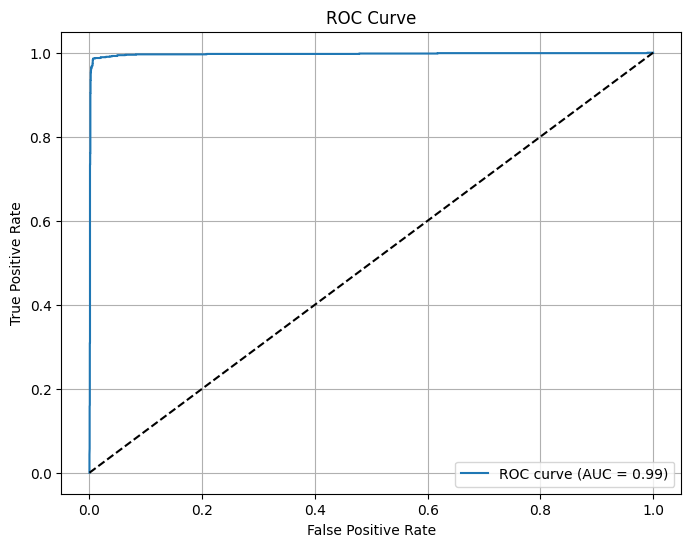

In [6]:
# Concatenate all batches
all_labels = torch.cat(all_labels).numpy()
all_probs = torch.cat(all_probs).numpy()

# Compute metrics
p=0.5
precision = precision_score(all_labels,(all_probs >= p).astype(int),  average="binary")
recall = recall_score(all_labels,(all_probs >= p).astype(int), average="binary")
f1 = f1_score(all_labels,(all_probs >= p).astype(int), average=None)[1]
auc=roc_auc_score(all_labels,(all_probs >= p).astype(int), average=None)

test_accuracy=correct / total

print('Test Accuracy: {:.2f} %, Precision: {:.2f} %, Recall: {:.2f} %, F1-Score: {:.2f} %, AUC: {:.2f} %'.format(
    test_accuracy * 100, precision * 100, recall * 100, f1 * 100, auc * 100))

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.savefig(path_dir + 'roc_curve.png')

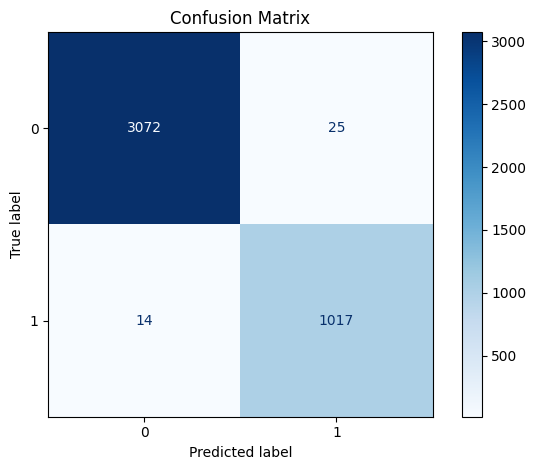

In [7]:
# Confusion Matrix
cm = confusion_matrix(all_labels, (all_probs >= p).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

**Maximizing F1 score**

Inspect the precision-recall curve and f1 vs threshold score, and change threshold to maximise F1 score

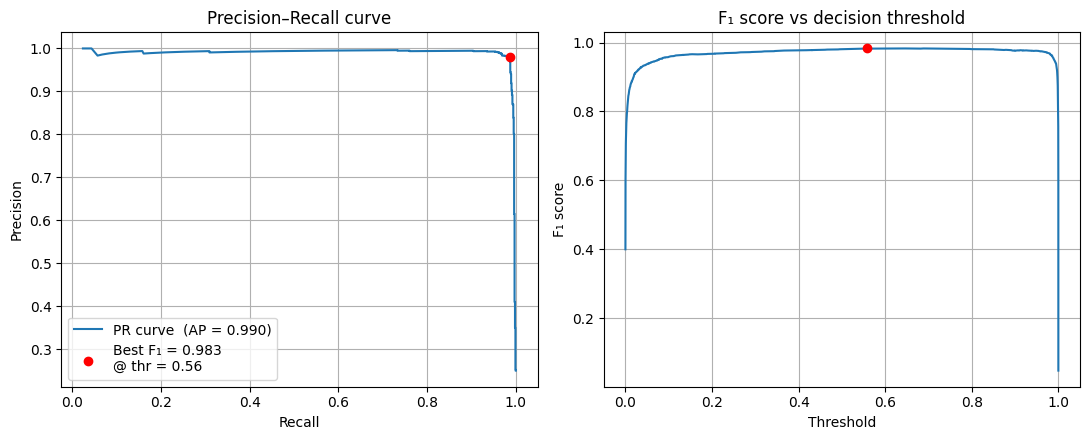

Optimal threshold = 0.558  |  Best F1 = 0.983


In [9]:

def pr_and_f1_curves(y_true, y_prob):
    """
    Plot precision-recall curve and F1 vs threshold curve.
    """
    # PR data
    prec, rec, thresh = precision_recall_curve(y_true, y_prob)
    prec, rec = prec[:-1], rec[:-1]
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

    best_idx      = np.argmax(f1)
    best_thr      = thresh[best_idx]
    best_f1       = f1[best_idx]
    avg_prec      = average_precision_score(y_true, y_prob)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

    # Left: PR curve
    ax[0].plot(rec, prec, color='tab:blue', label=f'PR curve  (AP = {avg_prec:.3f})')
    ax[0].scatter(rec[best_idx], prec[best_idx], color='red', zorder=5,
                  label=f'Best F₁ = {best_f1:.3f}\n@ thr = {best_thr:.2f}')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision–Recall curve')
    ax[0].legend()
    ax[0].grid(True)

    # Right: F1 vs threshold
    ax[1].plot(thresh, f1, color='tab:blue')
    ax[1].scatter(best_thr, best_f1, color='red', zorder=5)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('F₁ score')
    ax[1].set_title('F₁ score vs decision threshold')
    ax[1].grid(True)

    plt.tight_layout()
    plt.savefig(path_dir +'pr_f1.png')
    plt.show()

    return best_thr, best_f1

# Plot precision-recall and F1 vs threshold plots
best_thr, best_f1 = pr_and_f1_curves(all_labels, all_probs)
print(f"Optimal threshold = {best_thr:.3f}  |  Best F1 = {best_f1:.3f}")

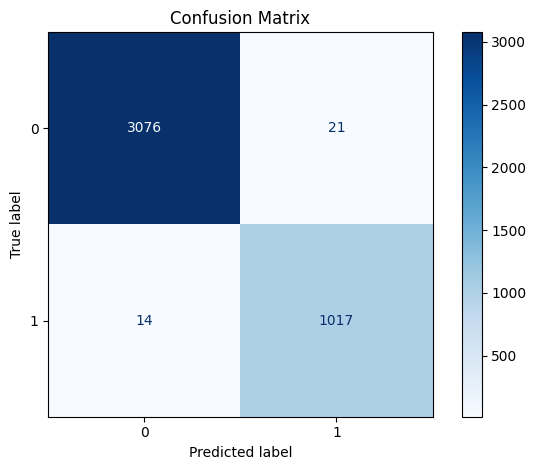

In [10]:
# Change threshold to maximise F1 score
final_preds = (np.array(all_probs) >= best_thr).astype(int)
# Confusion Matrix
cm = confusion_matrix(all_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig(path_dir + 'Confusion_matrix_optimised.png')